In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons

from micrograd import Value
from nn import MLP

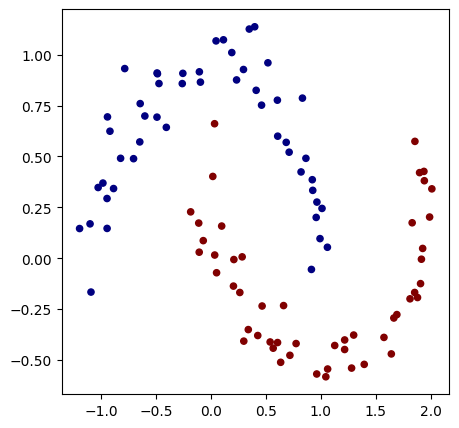

In [2]:
# make up a dataset
X, y = make_moons(n_samples=100, noise=0.1)

y = y * 2 - 1  # make y be -1 or 1

# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

In [3]:
# init the MLP model with 2 layers

model = MLP(2, [16, 16, 1])
print(model, "number of params", len(model.parameters()))

<nn.MLP object at 0x10c21d7f0> number of params 337


In [ ]:
# loss function
def loss():
    Xb, yb = X, y

    # convert input to neuron input value
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward-pass
    scores = [model(x) for x in inputs]

    # if the expected & actual score point in the same direction, then
    # score & label (yi) will be positive. Further, subtracting from 1
    # will make the value < 1 RelU will further trim the values to 0.
    # This way the loss will remain low.
    # However, if the score & label are in opposite directions, then
    # the loss will compulsorily remain above 1.
    # Hence in case of correct answer, loss remains in [0, 1] otherwise [1, +inf]
    losses = [(1 + (-yi * scorei)).relu() for scorei, yi in zip(scores, yb)]

    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization (weight decay): penalizes large weights by adding α * Σ(wi²)
    # This prevents overfitting by encouraging smaller, more distributed weights
    # rather than relying heavily on any single weight
    alpha = 1e-4
    reg_loss = sum((p * p for p in model.parameters())) * alpha

    total_loss = data_loss + reg_loss

    # this is more for info purpose.
    accuracy = [(yi > 0) == (scorei.data > 0) for scorei, yi in zip(scores, yb)]

    return total_loss, sum(accuracy) / len(accuracy)

In [ ]:
# optimisation
for k in range(100):
    total_loss, acc = loss()

    model.zero_grad()

    total_loss.backward()

    learning_rate = 1.0 - 0.9 * k / 100

    for p in model.parameters():
        p.data -= learning_rate * p.grad

    print(f"step {k} loss {total_loss.data}, accuracy {acc * 100}%")

(-1.581767921066486, 1.918232078933514)

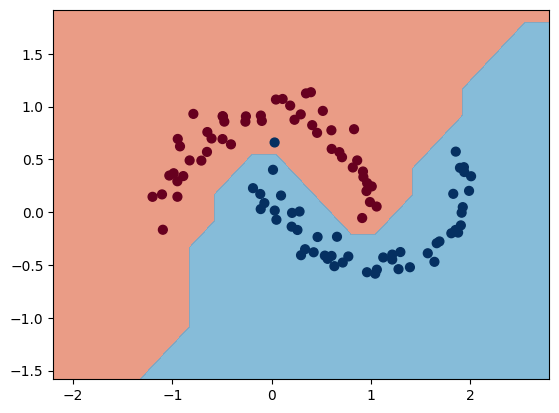

In [6]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())